In [1]:
from scipy import stats
from scipy.stats import chi2_contingency
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.anova import anova_lm
import scipy.stats as st
import statsmodels.formula.api as smf
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv('/Users/sili/Downloads/Data.csv')
df.head()

,random_user_id,user_first_touch_timestamp,key,category,operating_system,country,event_timestamp,experimentVariant,eventName
0,17748,2019-08-25 22:59:00.363 UTC,firebase_exp_9,mobile,IOS,Japan,2019-08-25 22:59:50.406 UTC,Variant A,tutorial_step1
1,29382,2019-08-25 22:58:53.145 UTC,firebase_exp_9,mobile,IOS,Japan,2019-08-25 22:59:56.532 UTC,Variant A,tutorial_step1
2,7729,2019-08-25 18:01:12.702 UTC,firebase_exp_9,mobile,IOS,Saudi Arabia,2019-08-25 18:13:50.313 UTC,Control group,share
3,57750,2019-08-25 22:58:55.244 UTC,firebase_exp_9,mobile,IOS,Russia,2019-08-25 22:59:28.314 UTC,Variant A,carousel_next
4,57750,2019-08-25 22:58:55.244 UTC,firebase_exp_9,mobile,IOS,Russia,2019-08-25 22:59:34.647001 UTC,Variant A,carousel_next


In [3]:
df.random_user_id.nunique()

74941

In [4]:
df.groupby('experimentVariant').nunique()['random_user_id']

experimentVariant
Control group    37671
Variant A        37360
Name: random_user_id, dtype: int64

- Since the p-value is 0.23, we fail to reject the null hypothesis and conclude there is no evidence of SRM
- However, it seems some users are in both control and variant groups

In [5]:
# count the number of users are in both control and variant groups

df['duplicates'] = df[df['experimentVariant']=='Variant A']['random_user_id'].isin(
    df[df['experimentVariant']=='Control group']['random_user_id'])

In [6]:
# remove those users as they interfere with the results of the test

df = df[~df['random_user_id'].isin(df[df.duplicates==True]['random_user_id'])].copy() 

In [7]:
# count the number of legit users who entered the experiment

df['random_user_id'].nunique()

74851

In [8]:
# count the number of legit users in the either control or variant group

df.groupby('experimentVariant').nunique()['random_user_id']

experimentVariant
Control group    37581
Variant A        37270
Name: random_user_id, dtype: int64

In [9]:
# have a look at the event in control group

set(df[df['experimentVariant']=='Control group']['eventName'])

{'directions',
 'menu_settings',
 'save_location',
 'search',
 'search_3wa',
 'share',
 'sign_up',
 'tutorial_dismiss',
 'tutorial_step1',
 'tutorial_step4'}

In [10]:
# have a look at the event in variant group

set(df[df['experimentVariant']=='Variant A']['eventName'])

{'carousel_next',
 'directions',
 'menu_settings',
 'save_location',
 'search',
 'search_3wa',
 'share',
 'sign_up',
 'tutorial_dismiss',
 'tutorial_step1',
 'tutorial_step4'}

carousel_next as a new feature was introduced to the variant group

In [11]:
# convert to date

df['user_first_touch_timestamp'] = pd.to_datetime(df['user_first_touch_timestamp'])
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])

In [12]:
# calculate number of days after first touch

df['days_after_first_touch'] = df['event_timestamp'] - df['user_first_touch_timestamp'] 

In [13]:
df[df['days_after_first_touch']<datetime.timedelta(days=0)]

,random_user_id,user_first_touch_timestamp,key,category,operating_system,country,event_timestamp,experimentVariant,eventName,duplicates,days_after_first_touch
270970,1702,2019-08-26 01:30:02.960,firebase_exp_9,mobile,IOS,United States,2019-08-25 01:31:10.861000,Variant A,tutorial_step1,False,-1 days +00:01:07.901000
270971,1702,2019-08-26 01:30:02.960,firebase_exp_9,mobile,IOS,United States,2019-08-25 01:31:20.660000,Variant A,carousel_next,False,-1 days +00:01:17.700000
270973,1702,2019-08-26 01:30:02.960,firebase_exp_9,mobile,IOS,United States,2019-08-25 01:31:21.927001,Variant A,carousel_next,False,-1 days +00:01:18.967001
270974,1702,2019-08-26 01:30:02.960,firebase_exp_9,mobile,IOS,United States,2019-08-25 01:31:22.843002,Variant A,carousel_next,False,-1 days +00:01:19.883002
270975,1702,2019-08-26 01:30:02.960,firebase_exp_9,mobile,IOS,United States,2019-08-25 01:31:34.295006,Variant A,tutorial_dismiss,False,-1 days +00:01:31.335006
270977,1702,2019-08-26 01:30:02.960,firebase_exp_9,mobile,IOS,United States,2019-08-25 01:32:16.245000,Variant A,search,False,-1 days +00:02:13.285000
270978,1702,2019-08-26 01:30:02.960,firebase_exp_9,mobile,IOS,United States,2019-08-25 01:32:16.245001,Variant A,search_3wa,False,-1 days +00:02:13.285001


In [14]:
# remove rows event_stamp is before user_first_touch_timestamp

df = df[df['days_after_first_touch']>=datetime.timedelta(days=0)].copy() 

In [15]:
len(df)

345035

In [16]:
# generate three columns to see if users are still active (retained) after 1, 3, 7 days respectively

df['1_day_retention'] = np.where(df['days_after_first_touch']>datetime.timedelta(days=1), 1, 0)
df['3_day_retention'] = np.where(df['days_after_first_touch']>datetime.timedelta(days=3), 1, 0)
df['7_day_retention'] = np.where(df['days_after_first_touch']>datetime.timedelta(days=7), 1, 0)

In [17]:
# filter the dataframe to show the last time each user has logged into the App
# now it's clear if a user is still active after 1, 3, 7 days respectively

retention = df.sort_values(['random_user_id', 'user_first_touch_timestamp', 'event_timestamp'], 
            ascending=[True, True, False]).groupby('random_user_id').head(1)

# or df.sort_values(['random_user_id', 'user_first_touch_timestamp', 'event_timestamp'], ascending=[True, True, False]).drop_duplicates(subset=['random_user_id'])

In [18]:
# qualified unique users in control vs variant

retention.groupby('experimentVariant').count()['random_user_id']

experimentVariant
Control group    37581
Variant A        37269
Name: random_user_id, dtype: int64

In [19]:
# parameters for power analysis 
# effect_size has to be positive
effect = 0.01
alpha = 0.05
power = 0.8
# perform power analysis 
analysis = TTestIndPower()
result = analysis.solve_power(effect, power = power,nobs1= None, ratio = 1.0, alpha = alpha)
print('Ideal Sample Size: %.3f' % round(result))

Ideal Sample Size: 156978.000


# Chi Squared Test & T Test 

Karl Pearson’s famous chi-square contingency test is derived from z statistic, based on the Normal distribution (degree of freedom = 1). It's suitable in this case as there are 2 categorical variables - experimentVariant vs retain or not. Also, T test is approximates Z distribution when sample gets big. So both tests both are performed to access the statistical significance.

## 1 Day Retention

In [20]:
retention.groupby('experimentVariant').mean()['1_day_retention']

experimentVariant
Control group    0.059817
Variant A        0.060560
Name: 1_day_retention, dtype: float64

### T Test

In [21]:
test_result = stats.ttest_ind(retention[retention['experimentVariant']=='Variant A']['1_day_retention'],
                              retention[retention['experimentVariant']=='Control group']['1_day_retention'])
print(test_result)

Ttest_indResult(statistic=0.42691059943956944, pvalue=0.6694456729102755)


### Chi Squared Test

In [22]:
_, (a, c) = np.unique(retention[retention['experimentVariant']=='Control group']['1_day_retention'], return_counts=True)
_, (b, d) = np.unique(retention[retention['experimentVariant']=='Variant A']['1_day_retention'], return_counts=True)

df_chi_1 = pd.DataFrame(data=[[a, b], [c, d]], 
                 index=["not retained", "retained"], 
                 columns=["A", "B"])
m = df_chi_1.values

In [23]:
chi2_val, p_val = chi2_contingency(m, correction=False)[:2]

print("- Pearson's chi-squared t-test:")
print(f"   - χ2 value: {chi2_val:.3f}")
print(f"   - p-value: {p_val:}")

- Pearson's chi-squared t-test:
   - χ2 value: 0.182
   - p-value: 0.6694406690887797


## 3 Day Retention

In [24]:
retention.groupby('experimentVariant').mean()['3_day_retention']

experimentVariant
Control group    0.029110
Variant A        0.030427
Name: 3_day_retention, dtype: float64

### T Test

In [25]:
test_result = stats.ttest_ind(retention[retention['experimentVariant']=='Variant A']['3_day_retention'],
                              retention[retention['experimentVariant']=='Control group']['3_day_retention'])
print(test_result)

Ttest_indResult(statistic=1.0600791641627452, pvalue=0.2891120066972475)


### Chi Squared Test

In [26]:
_, (a, c) = np.unique(retention[retention['experimentVariant']=='Control group']['3_day_retention'], return_counts=True)
_, (b, d) = np.unique(retention[retention['experimentVariant']=='Variant A']['3_day_retention'], return_counts=True)

df_chi_3 = pd.DataFrame(data=[[a, b], [c, d]], 
                 index=["not retained", "retained"], 
                 columns=["A", "B"])
m = df_chi_3.values

In [27]:
chi2_val, p_val = chi2_contingency(m, correction=False)[:2]

print("- Pearson's chi-squared t-test:")
print(f"   - χ2 value: {chi2_val:.3f}")
print(f"   - p-value: {p_val:}")

- Pearson's chi-squared t-test:
   - χ2 value: 1.124
   - p-value: 0.2891057633157396


## 7 Day Retention

In [28]:
retention.groupby('experimentVariant').mean()['7_day_retention']

experimentVariant
Control group    0.008142
Variant A        0.009633
Name: 7_day_retention, dtype: float64

### T Test

In [29]:
test_result = stats.ttest_ind(retention[retention['experimentVariant']=='Variant A']['7_day_retention'],
                              retention[retention['experimentVariant']=='Control group']['7_day_retention'])
print(test_result)

Ttest_indResult(statistic=2.1724734305137527, pvalue=0.02982309890774258)


In [30]:
# effect size
retention[retention['experimentVariant']=='Variant A']['7_day_retention'].mean() - retention[retention['experimentVariant']=='Control group']['7_day_retention'].mean()

0.0014902581948923414

In [31]:
retention.groupby('experimentVariant').sum()['7_day_retention']

experimentVariant
Control group    306
Variant A        359
Name: 7_day_retention, dtype: int64

### Chi Squared Test

In [32]:
_, (a, c) = np.unique(retention[retention['experimentVariant']=='Control group']['7_day_retention'], return_counts=True)
_, (b, d) = np.unique(retention[retention['experimentVariant']=='Variant A']['7_day_retention'], return_counts=True)

df_chi_7 = pd.DataFrame(data=[[a, b], [c, d]], 
                 index=["not retained", "retained"], 
                 columns=["A", "B"])
m = df_chi_7.values

chi2_val, p_val = chi2_contingency(m, correction=False)[:2]

print("- Pearson's chi-squared t-test:")
print(f"   - χ2 value: {chi2_val:.3f}")
print(f"   - p-value: {p_val:}")

- Pearson's chi-squared t-test:
   - χ2 value: 4.719
   - p-value: 0.02982294554487561


### Confidence Internval

In [33]:
# create two series to calculate confidence interval later
control_series = retention[retention['experimentVariant']=='Control group']['7_day_retention']
variant_series = retention[retention['experimentVariant']=='Variant A']['7_day_retention']

In [34]:
# calculate confidence interval for retention rate of control group

print('control retention rate confidence interval')
st.t.interval(0.95, len(control_series)-1, loc=np.mean(control_series), scale=st.sem(control_series))

control retention rate confidence interval


(0.007233786936763427, 0.00905103784171506)

In [35]:
# calculate confidence interval for retention rate of variant group

print('variant retention rate confidence interval')
st.t.interval(0.95, len(variant_series)-1, loc=np.mean(variant_series), scale=st.sem(variant_series))

variant retention rate confidence interval


(0.008641004044984572, 0.010624337123278597)

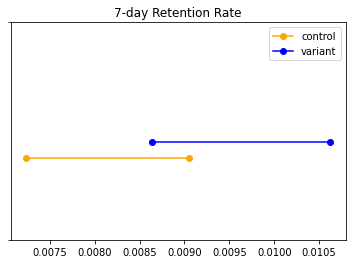

In [36]:
# plot confidence intervals of 
plt.plot(st.t.interval(0.95, len(control_series)-1, loc=np.mean(control_series), scale=st.sem(control_series)), (1.75,1.75), 'ro-',color='orange')
plt.plot(st.t.interval(0.95, len(variant_series)-1, loc=np.mean(variant_series), scale=st.sem(variant_series)), (1.9,1.9), 'ro-',color='blue')
plt.yticks((1,3), [])
plt.legend(['control', 'variant'])
plt.title('7-day Retention Rate');

- The confidence interval of two groups are overlapping which means we don't have a definite winner even that the t test is significant nor can we measure the size of effect

# Two-way ANOVA

Wondering if mobile device has an impact so a two-way ANOVA is performed

In [37]:
# interested in mobile device. Would that make a difference?

retention['sevendayretention'] = retention['7_day_retention'] # update variable name

model = smf.ols(formula='sevendayretention ~ experimentVariant + category', data=retention).fit()
aov_table = anova_lm(model, typ=2)
print(np.round(aov_table,4))

                     sum_sq       df       F  PR(>F)
experimentVariant    0.0417      1.0  4.7331  0.0296
category             0.0078      1.0  0.8802  0.3482
Residual           659.0425  74847.0     NaN     NaN


- mobile device is not relevant in this case as it's not significant

# Bootstrap

As the experiment is not running for a long time and a moderate sample size is gathered. It would be helpful to understand if the experiment is reproduceable. Therefore, bootstrapping differences of control vs variant retention rate is used to test experiment validity

## 1 Day Retention

In [38]:
# Display observed difference in retention rates

obs_diff = retention[retention['experimentVariant']=='Variant A']['1_day_retention'].mean() - retention[retention['experimentVariant']=='Control group']['1_day_retention'].mean()
obs_diff

0.0007422535570236893

In [39]:
# Create sampling distribution for difference in retention rates with boostrapping

diffs = []
size = retention.shape[0]
for _ in range(10000):
    b_samp = retention.sample(size, replace=True)
    control_df = b_samp.query('experimentVariant == "Control group"')
    experiment_df = b_samp.query('experimentVariant == "Variant A"')
    control_ctr = control_df['1_day_retention'].mean()
    experiment_ctr = experiment_df['1_day_retention'].mean()
    diffs.append(experiment_ctr - control_ctr)

In [40]:
# convert to numpy array
diffs = np.array(diffs)

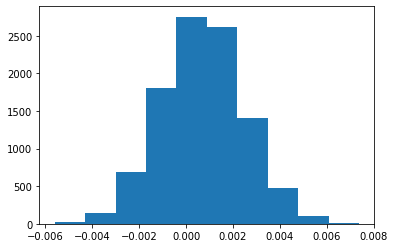

In [41]:
# plot distribution
plt.hist(diffs);

In [42]:
# create distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), diffs.size)

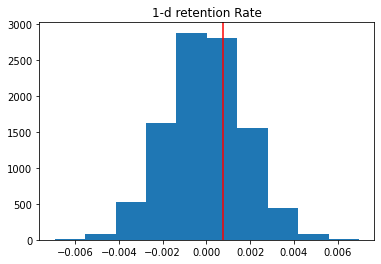

In [43]:
# plot null distribution
plt.hist(null_vals);

# plot line for observed statistic
plt.axvline(obs_diff, c='red')
plt.title('1-d retention Rate');

In [44]:
# compute p value
(null_vals > obs_diff).mean()

0.3329

## 3 Day Retention

0.2229

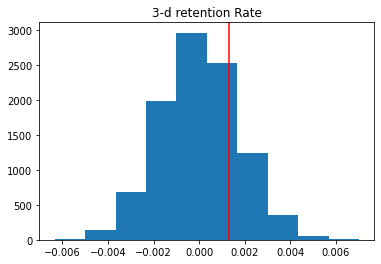

In [45]:
# Calculate observed difference in retention rates

obs_diff = retention[retention['experimentVariant']=='Variant A']['3_day_retention'].mean() - retention[retention['experimentVariant']=='Control group']['3_day_retention'].mean()

# Create sampling distribution for difference in retention rates with boostrapping

diffs = []
size = retention.shape[0]
for _ in range(10000):
    b_samp = retention.sample(size, replace=True)
    control_df = b_samp.query('experimentVariant == "Control group"')
    experiment_df = b_samp.query('experimentVariant == "Variant A"')
    control_ctr = control_df['1_day_retention'].mean()
    experiment_ctr = experiment_df['1_day_retention'].mean()
    diffs.append(experiment_ctr - control_ctr)

# convert to numpy array
diffs = np.array(diffs)
    
# create distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), diffs.size)

# plot null distribution
plt.hist(null_vals);

# plot line for observed statistic
plt.axvline(obs_diff, c='red')
plt.title('3-d retention Rate');

# compute p value
(null_vals > obs_diff).mean()

# 7 Day Retention

0.1893

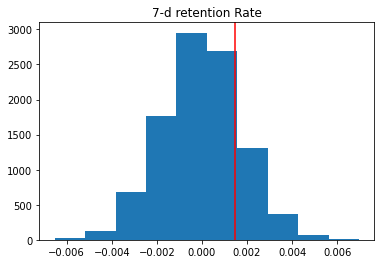

In [46]:
# Calculate observed difference in retention rates

obs_diff = retention[retention['experimentVariant']=='Variant A']['7_day_retention'].mean() - retention[retention['experimentVariant']=='Control group']['7_day_retention'].mean()

# Create sampling distribution for difference in retention rates with boostrapping

diffs = []
size = retention.shape[0]
for _ in range(10000):
    b_samp = retention.sample(size, replace=True)
    control_df = b_samp.query('experimentVariant == "Control group"')
    experiment_df = b_samp.query('experimentVariant == "Variant A"')
    control_ctr = control_df['1_day_retention'].mean()
    experiment_ctr = experiment_df['1_day_retention'].mean()
    diffs.append(experiment_ctr - control_ctr)

# convert to numpy array
diffs = np.array(diffs)

# create distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), diffs.size)

# plot null distribution
plt.hist(null_vals);

# plot line for observed statistic
plt.axvline(obs_diff, c='red')
plt.title('7-d retention Rate');

# compute p value
(null_vals > obs_diff).mean()